In [4]:
import math
import time

import matplotlib.pyplot as pyplot
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import tensorflow as tf

In [5]:
FTRAIN = "/Users/chang12/projects/kaggle/facial-keypoint-detection/training.csv"
FTEST = "/Users/chang12/projects/kaggle/facial-keypoint-detection/test.csv"

def load(test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)

    df["Image"] = df["Image"].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols) + ["Image"]]
        
    print(df.count())
    df = df.dropna()

    X = np.vstack(df["Image"].values) / 255.
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [6]:
X, y = load()

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [7]:
# https://www.tensorflow.org/get_started/mnist/mechanics

images = tf.placeholder(tf.float32, shape=(None, 9216))
truth = tf.placeholder(tf.float32, shape=(None, 30))

with tf.name_scope("hidden"):
    weights = tf.Variable(tf.truncated_normal([9216, 100], stddev=1.0 / math.sqrt(float(9216))), name="weights")
    biases = tf.Variable(tf.zeros([100]), name="biases")
    hidden = tf.nn.relu(tf.matmul(images, weights) + biases)
with tf.name_scope("mse_linear"):
    weights = tf.Variable(tf.truncated_normal([100, 30], stddev=1.0 / math.sqrt(float(100))), name="weights")
    biases = tf.Variable(tf.zeros([30]), name="biases")
    predict = tf.matmul(hidden, weights) + biases
    
loss = tf.losses.mean_squared_error(truth, predict)
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True).minimize(loss)

# 요렇게만 해도 optimization 의 대상인 optimizer 를 만들 수 있었다.
# MNIST 쪽 예제에서는 global_step 을 만들어서 추가로 넣어줬었다.
# global_step = tf.Variable(0, name="global_step", trainable=False)
# train_op = optimizer.minimize(loss, global_step=global_step)

tensorflow feed forward example 로 검색해서 나온 [코드를](https://gist.github.com/vinhkhuc/e53a70f9e5c3f55852b0) 참고해봤다.

mini-batch training 에 필요한 hyper-parameter 들은 [Kaggle 이 소개한 블로그 포스트를](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) 따라해보자.

위의 블로그 포스트에서도 첫번째 model 에서는 full-batch 로 학습시키는것 같으므로, 우선은 mini-batch 는 구현하지 않고 진행해보자.

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)  # initializer 를 만들고 한번 run 해주지 않으면, 이후 sess.run() 에서 예외가 발생한다.

num_epoch = 400  # 블로그 포스트를 따라함
feed_dict = {images: X, truth: y}  # 한번 assign 해두고 써도 괜찮지 않을까?

for e in range(num_epoch):
    start_ms = int(time.time() * 1000)
    sess.run(optimizer, feed_dict=feed_dict)
    training_loss = sess.run(loss, feed_dict=feed_dict)
    elapsed_ms = int(time.time() * 1000) - start_ms
    
    print("Epoch: {:4d}\tTraining Loss: {:.7f}\tElapsed Time(ms): {:6d}".format(e, training_loss, elapsed_ms))

Epoch:    0	Training Loss: 0.0934343	Elapsed Time(ms):    239
Epoch:    1	Training Loss: 0.0595242	Elapsed Time(ms):    208
Epoch:    2	Training Loss: 0.0488765	Elapsed Time(ms):    237
Epoch:    3	Training Loss: 0.0381642	Elapsed Time(ms):    236
Epoch:    4	Training Loss: 0.0304342	Elapsed Time(ms):    234
Epoch:    5	Training Loss: 0.0267957	Elapsed Time(ms):    216
Epoch:    6	Training Loss: 0.0242700	Elapsed Time(ms):    213
Epoch:    7	Training Loss: 0.0216313	Elapsed Time(ms):    211
Epoch:    8	Training Loss: 0.0195253	Elapsed Time(ms):    225
Epoch:    9	Training Loss: 0.0182197	Elapsed Time(ms):    223
Epoch:   10	Training Loss: 0.0174986	Elapsed Time(ms):    217
Epoch:   11	Training Loss: 0.0170257	Elapsed Time(ms):    231
Epoch:   12	Training Loss: 0.0166215	Elapsed Time(ms):    236
Epoch:   13	Training Loss: 0.0162257	Elapsed Time(ms):    215
Epoch:   14	Training Loss: 0.0158431	Elapsed Time(ms):    213
Epoch:   15	Training Loss: 0.0155365	Elapsed Time(ms):    215
Epoch:  

Epoch:  133	Training Loss: 0.0095086	Elapsed Time(ms):    208
Epoch:  134	Training Loss: 0.0094898	Elapsed Time(ms):    208
Epoch:  135	Training Loss: 0.0094711	Elapsed Time(ms):    208
Epoch:  136	Training Loss: 0.0094525	Elapsed Time(ms):    250
Epoch:  137	Training Loss: 0.0094341	Elapsed Time(ms):    257
Epoch:  138	Training Loss: 0.0094158	Elapsed Time(ms):    250
Epoch:  139	Training Loss: 0.0093976	Elapsed Time(ms):    232
Epoch:  140	Training Loss: 0.0093795	Elapsed Time(ms):    233
Epoch:  141	Training Loss: 0.0093616	Elapsed Time(ms):    239
Epoch:  142	Training Loss: 0.0093437	Elapsed Time(ms):    231
Epoch:  143	Training Loss: 0.0093260	Elapsed Time(ms):    250
Epoch:  144	Training Loss: 0.0093084	Elapsed Time(ms):    247
Epoch:  145	Training Loss: 0.0092909	Elapsed Time(ms):    221
Epoch:  146	Training Loss: 0.0092735	Elapsed Time(ms):    441
Epoch:  147	Training Loss: 0.0092563	Elapsed Time(ms):    303
Epoch:  148	Training Loss: 0.0092391	Elapsed Time(ms):    301
Epoch:  

Epoch:  266	Training Loss: 0.0077428	Elapsed Time(ms):    214
Epoch:  267	Training Loss: 0.0077333	Elapsed Time(ms):    216
Epoch:  268	Training Loss: 0.0077238	Elapsed Time(ms):    212
Epoch:  269	Training Loss: 0.0077144	Elapsed Time(ms):    211
Epoch:  270	Training Loss: 0.0077051	Elapsed Time(ms):    210
Epoch:  271	Training Loss: 0.0076957	Elapsed Time(ms):    207
Epoch:  272	Training Loss: 0.0076864	Elapsed Time(ms):    206
Epoch:  273	Training Loss: 0.0076772	Elapsed Time(ms):    221
Epoch:  274	Training Loss: 0.0076679	Elapsed Time(ms):    211
Epoch:  275	Training Loss: 0.0076588	Elapsed Time(ms):    209
Epoch:  276	Training Loss: 0.0076496	Elapsed Time(ms):    216
Epoch:  277	Training Loss: 0.0076405	Elapsed Time(ms):    219
Epoch:  278	Training Loss: 0.0076314	Elapsed Time(ms):    216
Epoch:  279	Training Loss: 0.0076224	Elapsed Time(ms):    213
Epoch:  280	Training Loss: 0.0076134	Elapsed Time(ms):    216
Epoch:  281	Training Loss: 0.0076044	Elapsed Time(ms):    210
Epoch:  

Epoch:  399	Training Loss: 0.0067375	Elapsed Time(ms):    281


블로그 포스트에서는 `0.002244` 였는데, 나는 `0.0069261` 로 3배 정도 크게 나왔다.

심지어 블로그 포스트에서는 validation loss 이고, 나는 training loss 인데...!!

In [9]:
np.sqrt(0.0069261) * 48

3.9947133063587934

테스트 이미지에 keypoint 를 그려보는것도 블로그 포스트의 코드를 그대로 사용했다.

크기를 키우고 (`figsize`), marker 크기와(`s`), 색깔에(`c`) 변화를 줬다.

In [17]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap="gray")
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=50, c='r')

In [11]:
X_test, _ = load(test=True)
y_pred = sess.run(predict, feed_dict={images: X_test})

ImageId    1783
Image      1783
dtype: int64


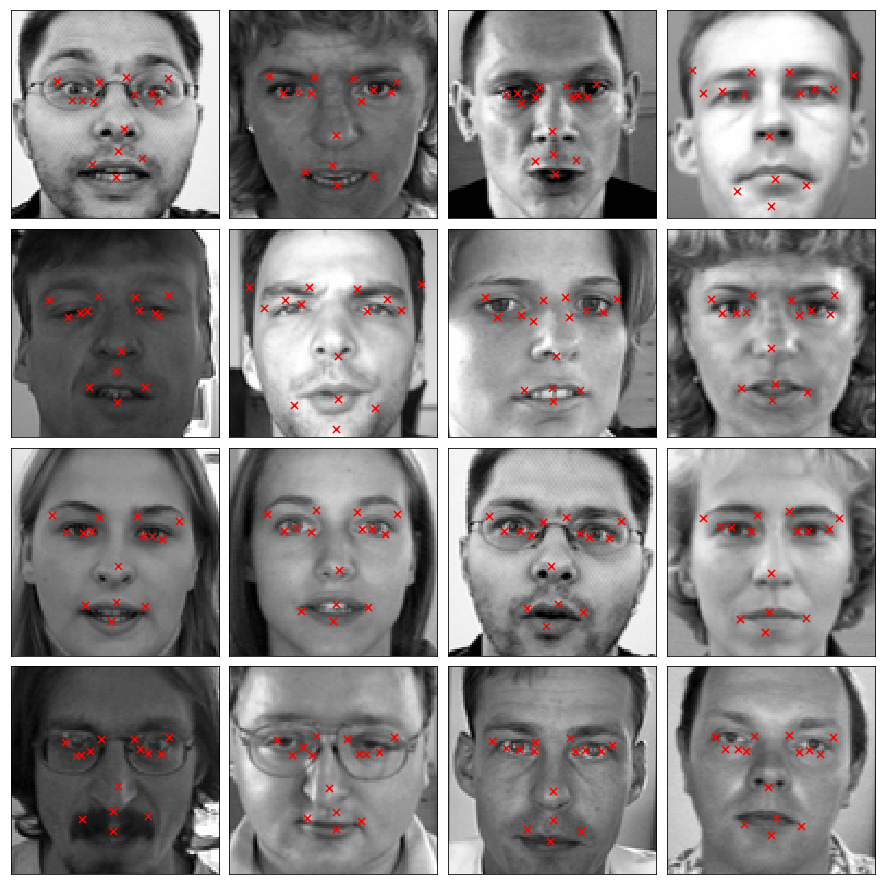

In [18]:
fig = pyplot.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)
    
pyplot.show()